# Pixel Cart Game
# Homework 03 - Deep Reinforcement Learning
*Neural Networks and Deep Learning* 
*Lecture by Prof. Alberto Testolin*\
*@ the University of Padova* \
*Winter term 2021/22* \

*Nathanael Schmidt-Ott* \
*Master student in Applied Statistics* \
*@ Göttingen University* \
*Guest Student at the Univeristy of Padova* 
 
ursnathanael.schmidtott@studenti.unipd.it


In [1]:
# mount drive
# from google.colab import drive
# drive.mount('/content/gdrive')
# % cd /content/gdrive/MyDrive/NNDL_PD/HW_3/

import os 
if not os.path.isdir("plots"):
  os.makedirs("plots")
  os.makedirs("plots/gifs/episode_100")
  os.makedirs("plots/gifs/episode_final")

if not os.path.isdir("models"):
  os.makedirs("models")

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
/content/gdrive/MyDrive/NNDL_PD/HW_3


In [2]:
!pip install gym

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
import random
import torch
import numpy as np
import pandas as pd
import os 
import gym
import matplotlib.pyplot as plt
from tqdm import tqdm
import time
import pickle 
import cv2

from torch import nn
from collections import deque

In [4]:
!apt update
!apt-get install python-opengl -y
!apt install xvfb -y
!pip install pyvirtualdisplay
!pip install piglet

Hit:1 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease
Hit:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Ign:3 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:4 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Get:5 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Hit:6 http://archive.ubuntu.com/ubuntu bionic InRelease
Hit:7 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease
Get:8 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Hit:9 http://ppa.launchpad.net/cran/libgit2/ubuntu bionic InRelease
Hit:10 http://ppa.launchpad.net/deadsnakes/ppa/ubuntu bionic InRelease
Get:11 http://archive.ubuntu.com/ubuntu bionic-backports InRelease [74.6 kB]
Hit:13 http://ppa.launchpad.net/graphics-drivers/ppa/ubuntu bionic InRelease
Fetched 252 kB in 3s (83.4 kB/s)
Reading package li

In [5]:
import glob
import io
import base64
import os
from IPython.display import HTML
from IPython import display as ipythondisplay
from pyvirtualdisplay import Display
from gym.wrappers import Monitor

In [6]:
display = Display(visible=0, size=(1400, 900))
display.start()

In [7]:
# This code creates a virtual display to draw game images on. 
if type(os.environ.get("DISPLAY")) is not str or len(os.environ.get("DISPLAY"))==0:
    !bash ../xvfb start
    %env DISPLAY=:1

In [8]:
# """
# Utility functions to enable video recording of gym environment and displaying it
# To enable video, just do "env = wrap_env(env)""
# """

def show_videos():
  mp4list = glob.glob('video/*.mp4')
  mp4list.sort()
  for mp4 in mp4list:
    print(f"\nSHOWING VIDEO {mp4}")
    video = io.open(mp4, 'r+b').read()
    encoded = base64.b64encode(video)
    ipythondisplay.display(HTML(data='''<video alt="test" autoplay 
                loop controls style="height: 400px;">
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii'))))
    
def wrap_env(env, video_callable=None):
  env = Monitor(env, './video', force=True, video_callable=video_callable)
  return env

# define model

In [9]:
class DQCNN(nn.Module):
    def __init__(self, n_frames, input_shape, action_space_dim = 2):
        super().__init__()
        
        self.input_shape = input_shape
        kernel_size = 8
        stride = 4
        
        self.CNN = nn.Sequential(
                nn.Conv2d(in_channels  = n_frames,
                          out_channels = 16,
                          kernel_size  = 8,
                          stride       = 4),
                nn.ReLU(),
                nn.Conv2d(in_channels  = 16,  
                          out_channels = 32,
                          kernel_size  = 4,
                          stride       = 2),
                nn.ReLU(),
                nn.Flatten()
                )
        
        n_output_channels = 32

        #compute authomatically the resulting dimensions fr the elaborated picture
        first_layer_out_shape = self.cnn_out_shape(self.input_shape, 8, 0, 4)
        second_layer_out_shape = self.cnn_out_shape(first_layer_out_shape, 4, 0, 2)

        self.flat_dim = n_output_channels * int(second_layer_out_shape[0] * second_layer_out_shape[1])
        self.linear = nn.Sequential(
                nn.Linear(self.flat_dim, 256),
                nn.ReLU(),
                nn.Linear(256, 128),
                nn.ReLU(),
                nn.Linear(128, action_space_dim)
                )
        return
    
    def cnn_out_shape(self, shape, kernel_size, padding, stride):
      rows = int((shape[0] - kernel_size + 2*padding)/stride + 1)
      cols = int((shape[1] - kernel_size + 2*padding)/stride + 1)
      return (rows, cols)
    
    def forward(self, x):
        x = self.CNN(x)
        x = self.linear(x)
        return x
      

# Define action class

In [10]:
### Define exploration profile
class Exploration_profile():
  def __init__(self, initial_value, n_episodes, expl_type, decay_speed = 6):
    self.initial_value = initial_value
    self.n_episodes = n_episodes
    self.decay_speed = decay_speed

    profile = list(map(lambda i : initial_value*np.exp(-i*decay_speed*np.log(10)/n_episodes), np.arange(0,n_episodes)))
    self.profile = np.array(profile)

    if expl_type == 'soft':
      self.expl_type = self.softmax
    elif expl_type == "eps_greedy":
      self.expl_type = self.eps_greedy
    else: 
      raise Exception("No valid exploration type given")
  
  def eps_greedy(self, net, state, epsilon):
    if epsilon > 1 or epsilon < 0:
        raise Exception('The epsilon value must be between 0 and 1')
                
    # Evaluate the network output from the current state
    with torch.no_grad():
        net.eval()
        state = np.array(state, dtype = np.float32)
        state = torch.tensor(state).unsqueeze(0)
        net_out = net(state).squeeze(0)

    # Get the best action (argmax of the network output)
    best_action = int(net_out.argmax())
    # Get the number of possible actions
    action_space_dim = net_out.shape[-1]

    # Select a non optimal action with probability epsilon, otherwise choose the best action
    if random.random() < epsilon:
        # List of non-optimal actions
        non_optimal_actions = [a for a in range(action_space_dim) if a != best_action]
        # Select randomly
        action = random.choice(non_optimal_actions)
    else:
        # Select best action
        action = best_action
        
    return action, net_out.numpy()

  def softmax(self, net, state, temperature):    
    if temperature < 0:
        raise Exception('The temperature value must be greater than or equal to 0 ')
    # If the temperature is 0, just select the best action using the eps-greedy policy with epsilon = 0
    if temperature == 0:
        return self.eps_greedy(net, state, 0)
    
    # Evaluate the network output from the current state
    with torch.no_grad():
        net.eval()
        state = np.array(state, dtype = np.float32)
        state = torch.tensor(state).unsqueeze(0)
        #state = torch.tensor(state, dtype=torch.float32).unsqueeze(0)
        net_out = net(state).squeeze(0)

    # Apply softmax with temp
    temperature = max(temperature, 1e-8) # set a minimum to the temperature for numerical stability
    softmax_out = nn.functional.softmax(net_out / temperature, dim=0).numpy()
    # Sample the action using softmax output as mass pdf
    all_possible_actions = np.arange(0, softmax_out.shape[-1])
    action = np.random.choice(all_possible_actions, p=softmax_out) # this samples a random element from "all_possible_actions" with the probability distribution p (softmax_out in this case)
    
    return action, net_out.numpy()
  
  def plot_profile(self):
    plt.plot(self.profile)
    plt.xlabel('Iteration')
    plt.ylabel('Parameter')
    plt.show()

# define Replay memory class

In [11]:
class ReplayMemory(object):

    def __init__(self, capacity):
        self.memory = deque(maxlen=capacity) # Define a queue with maxlen "capacity"

    def push(self, state, action, next_state, reward):
        self.memory.append((state, action, next_state, reward))

    def sample(self, batch_size):
        batch_size = min(batch_size, len(self)) # Get all the samples if the requested batch_size is higher than the number of sample currently in the memory
        return random.sample(self.memory, batch_size) # Randomly select "batch_size" samples

    def __len__(self):
        return len(self.memory) # Return the number of samples currently stored in the memory

# define the Agent

In [12]:
class Agent():
  def __init__(self, policy, action_space_dim, theta, horizontal_crop = True, seed = 2909):
    self.policy = policy
    self.action_space_dim = action_space_dim
    self.theta = theta
    self.horizontal = horizontal_crop
    self.seed = seed
    self.score = 0
    self.reward = 0
  
  # define functions so that the agent can deal with the environment
  def initialise_game(self):
    self.env = gym.make('CartPole-v1')
    self.env.seed(self.seed)
    self.env.reset()
    self.render_proc_state()
    self.state_shape = self.current_state.shape

  def reset_game(self):
    self.env.reset()
    self.render_proc_state()

  def close_game(self):
    self.env.close()
  
  def render_proc_state(self):
    self.current_state_rgb = self.env.render(mode = 'rgb_array')
    self.current_state = self.preproc_state(self.current_state_rgb)

  # define functions that preprocess the state
  def preproc_state(self, state): # high level wrapper
    x = self.crop_img(state)
    x = self.rescale_img(x)
    out = self.bw_img(x)
    return out 
  
  def crop_img(self, state): # crop the image
    # crop vertically
    lower = int(state.shape[0] * 0.4)
    upper = int(state.shape[0] * 0.8)
    state = state[lower:upper,:]

    # crop horizontally
    if self.horizontal:
      # the cart is 49 pixels large
      right_left_space = 30
      width = 49 + 2 * right_left_space
      px_val_line = np.where(state[:,0] == 0)[0][0]
      cart_edges = np.where(state[px_val_line+2,:] == 0)[0][[0,-1]]
      if int(cart_edges[0] - right_left_space) < 1:
        px_left_cut = int(0) 
        px_right_cut = int(width)
      elif int(cart_edges[1] + right_left_space) > (state.shape[1] - 1):
        px_left_cut = int(state.shape[1] - width)
        px_right_cut = int(state.shape[1])
      else:
        px_left_cut = int(cart_edges[0] - right_left_space)
        px_right_cut = int(cart_edges[1] + right_left_space)
      state = state[:,px_left_cut:px_right_cut]
    return state

  def bw_img(self, state): # make image black and white
    out = np.mean(state,axis = 2)
    out = out/255
    return out

  def rescale_img(self, state): # rescale the image accoring to factor theta
    width  = int(state.shape[1] * self.theta)
    height = int(state.shape[0] * self.theta)
    out = cv2.resize(state, (width, height), interpolation = cv2.INTER_AREA)
    return out

  # define functions to plot the rendered states
  def plot_state(self, path = None): # plot function for the image
    plt.imshow(self.current_state, cmap = 'gray')
    plt.tight_layout()
    if path is not None:
      plt.savefig(path, dpi = 300, bbox_inches='tight')
    plt.show()
  
  def plot_rgb_state(self, path = None):
    plt.imshow(self.current_state_rgb)
    plt.tight_layout()
    if path is not None:
      plt.savefig(path, dpi = 300, bbox_inches = 'tight')
    plt.show()

  # define functions to act on the environment
  def act(self, policy_net, state, tau):
    action, q_values = self.policy.expl_type(policy_net, state, tau)
    _, reward, done, _ = self.env.step(action)
    self.score += 1
    return action, q_values, reward, done



In [30]:
# define the training class
class Trainer():
  def __init__(self, policy_net, target_net, memory, C, bad_state_penalty, gamma, lr, batch_size, n_frames = 4,seed = 2909):
    self.policy_net = policy_net
    self.target_net = target_net
    self.replay_mem = memory
    self.bad_state_penalty = bad_state_penalty
    self.gamma = gamma
    self.batch_size = batch_size
    self.lr = lr
    self.seed = seed
    self.C = C
    self.n_frames = n_frames
    
    self.optimiser = torch.optim.RMSprop(self.policy_net.parameters(), lr = lr)
    self.loss_fn = nn.SmoothL1Loss()
    
    self.scores = []
    self.rewards = []
    self.loss = []
  
  def train_agent(self, agent, n_frames = 4):
    self.n_frames = n_frames
    agent.initialise_game() # let the agent initialise the game
    for episode_num, tau in enumerate(tqdm(agent.policy.profile)):
      # create lists to store the results
      episode_reward = []
      episode_loss = []
      agent.score = 0
      
      self.done = False # set to False

      # create a history to store previous rendered states
      self.frame_history = deque(maxlen = n_frames)
      for i in range(n_frames):
        self.frame_history.append(np.zeros(agent.state_shape))

      # reset the game and add to history
      agent.reset_game() # this resets the internal state of the agent
      current_state = agent.current_state
      self.frame_history.append(current_state)

      # play until the game is over
      while not self.done:
        input_state = self.get_input()
        action, q_values, reward, done = agent.act(self.policy_net, input_state, tau)
        self.done = done
        # if the game is over (i.e. done) update the reward 
        if self.done:
          reward += self.bad_state_penalty
          next_input_state = None
        else:
          agent.render_proc_state() # render the new state
          new_state = agent.current_state # extract the new state from the agent
          self.frame_history.append(new_state) # append the new state to the frame history
          next_input_state = self.get_input()
        
        # store the (s,a,s',r) tuple in the replay memory
        self.replay_mem.push(input_state, action, next_input_state, reward) # note that this can also be none!

        # update the network by sampling from the replay memory and using the update function
        if len(self.replay_mem) > 1000: 
          loss = self.update_step()
          episode_loss.append(loss)
        
        # finally add reward to the list
        episode_reward.append(reward)
      
      # store score and reward in class objects
      self.rewards.append(np.mean(episode_reward))
      if len(episode_loss) > 0:
        self.loss.append(np.mean(episode_loss))
      else:
        self.loss.append(np.nan)
      self.scores.append(agent.score)

      # update target_network if appropriate
      if episode_num % self.C == 0:
        self.target_net.load_state_dict(self.policy_net.state_dict())
    agent.close_game()
  
  def update_step(self):
    # sample from the replay memory
    batch = self.replay_mem.sample(self.batch_size)
    actual_batch_size = len(batch)

    # extract the (s,a,s',r) from the replay memory
    states = torch.tensor(np.array([s[0] for s in batch]), dtype = torch.float32)
    actions = torch.tensor(np.array([s[1] for s in batch]), dtype = torch.int64)
    rewards = torch.tensor(np.array([s[3] for s in batch]), dtype = torch.float32)

    # extract the new states but make sure that no state is none
    valid_new_states = torch.tensor(np.array([s[2] for s in batch if s[2] is not None]), dtype = torch.float32)
    valid_mask = torch.tensor(np.array([s[2] is not None for s in batch]), dtype = torch.bool)

    # compute the policy network value for the current states
    self.policy_net.train()
    state_action_values = self.policy_net(states).gather(1,actions.unsqueeze(1))

    # compute the value function
    next_state_values = torch.zeros(actual_batch_size)
    with torch.no_grad():
      self.target_net.eval()
      next_state_values[valid_mask] = self.target_net(valid_new_states).max(dim = 1)[0].detach()

    # compute the expected state action values
    expected_state_action_values = (rewards + (self.gamma * next_state_values)).unsqueeze(1)

    # calculate loss
    loss = self.loss_fn(state_action_values, expected_state_action_values)

    # optimise the parameters in the model
    self.optimiser.zero_grad()
    loss.backward()
    for param in self.policy_net.parameters():
        param.grad.data.clamp_(-1, 1)
    self.optimiser.step()

    return loss.detach().numpy()

  def initialise_history(self, state_shape):
    # create a history to store previous rendered states
    self.frame_history = deque(maxlen = self.n_frames)
    for i in range(self.n_frames):
      self.frame_history.append(np.zeros(state_shape))

  def get_input(self):
    if self.n_frames == 2:
        input_state = self.frame_history[-1] - self.frame_history[-2]
        input_state = np.expand_dims(input_state,0)
    else:
        input_state = np.array(list(self.frame_history))
    return input_state

  def mvg_avg(self, res_list, step_size = 100):
    avg = np.convolve(res_list, np.ones(step_size), 'valid') / step_size
    x = np.arange(step_size,len(res_list)+1)
    return np.array([x,avg])
  
  def plot_scores(self, step_size = 100,path = None):
    mvg = self.mvg_avg(self.scores, step_size)
    plt.figure(figsize = (7,7))
    plt.plot(mvg[0], mvg[1])
    plt.xlabel("Episode (Game number)")
    ylab = str(step_size) + "-Episode moving average score"
    plt.ylabel(ylab)
    plt.rcParams.update({'font.size': 14})
    plt.tight_layout()
    if path is not None:
      plt.savefig(path, dpi = 300, bbox_inches = 'tight')
    plt.show()
  
  def plot_loss(self, path = None):
    plt.figure(figsize = (7,7))
    plt.plot(self.loss)
    plt.xlabel("Episode (Game number)")
    plt.ylabel("loss")
    plt.rcParams.update({'font.size': 14})
    plt.tight_layout()
    if path is not None:
      plt.savefig(path, dpi = 300, bbox_inches = 'tight')
    plt.show()

  # define function to play the game
  def play_game(self, agent):
    agent.initialise_game()
    agent.score = 0
    agent.reward = 0
    done = False
    self.game_frames = []
    self.game_frames.append(agent.current_state_rgb)

    self.initialise_history(agent.state_shape)
    self.frame_history.append(agent.current_state)
    print("Start playing...")
    while not done:
      input_state = self.get_input()
      action, q_values, reward, done = agent.act(self.policy_net, input_state, 1e-4)
      if done:
        agent.reward += self.bad_state_penalty
        agent.current_state_rgb = np.zeros((agent.state_shape[0],agent.state_shape[1],3))
        agent.current_state = np.zeros(agent.state_shape)
      else:
        agent.reward += reward
        agent.render_proc_state() # render the new state
        new_state = agent.current_state # extract the new state from the agent
        self.frame_history.append(new_state) # append the new state to the frame history
      agent.score += 1
      self.game_frames.append(agent.current_state_rgb)
    
    print("Done - Score = ",str(agent.score),'- Total Reward =',str(agent.reward))

# Plot the RGB and the processed image

In [ ]:
n_episodes = 2000
eps_greedy = Exploration_profile(1,n_episodes,'eps_greedy',2)
agent = Agent(eps_greedy, 2, 0.5, horizontal_crop = True, seed = seed)
agent.initialise_game()
agent.plot_rgb_state(path = 'plots/full_pix_cart.png')
agent.plot_state(path = 'plots/final_pix_cart_pole.png')

# Fit the first difference model

In [41]:
seed = 2909
n_episodes = 1000

eps_greedy = Exploration_profile(1,n_episodes,'eps_greedy',2)
agent = Agent(eps_greedy, 2, 0.5, horizontal_crop = True, seed = seed)
agent.initialise_game()

torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

policy_net = DQCNN(1, agent.state_shape, 2)
target_net = DQCNN(1, agent.state_shape, 2)
target_net.load_state_dict(policy_net.state_dict())
memory = ReplayMemory(10000)

trainer = Trainer(policy_net, target_net, memory, 20, -1, 0.99, 1e-4, 128, 2,seed)
trainer.train_agent(agent, 2)

# save models
torch.save(trainer.policy_net.state_dict(), 'models/trainer_policy_net.pth')
torch.save(trainer.target_net.state_dict(), 'models/trainer_target_net.pth')

100%|██████████| 1000/1000 [1:02:22<00:00,  3.74s/it]


In [46]:
with open("models/trainer_scores.pickle",'wb') as f:
  pickle.dump(trainer.scores, f, protocol = pickle.HIGHEST_PROTOCOL)

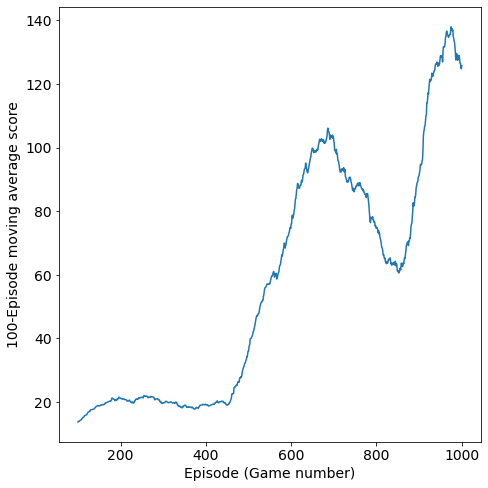

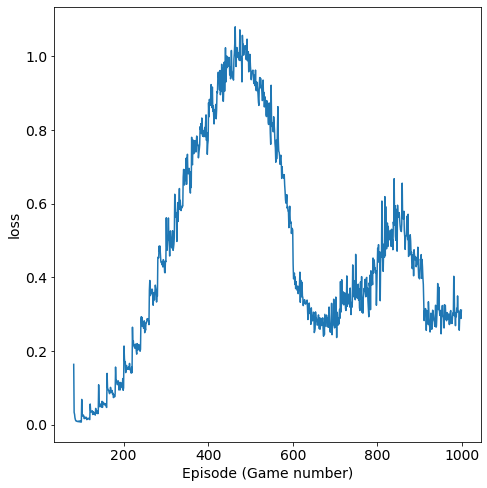

In [47]:
trainer.plot_scores(step_size = 100, path = 'plots/pixel_cart_pole_score_mvg.png')
trainer.plot_loss(path = 'plots/pixel_cart_pole_loss.png')

In [43]:

# import imageio
# from IPython.display import Image
# imageio.mimsave('plots/cart_final.gif', trainer.game_frames)
# Image(open('plots/cart_final.gif','rb').read())

# Train one model with four frames rather than the last difference

In [14]:
seed = 2909
n_episodes = 1000

eps_greedy = Exploration_profile(0.9,n_episodes,'eps_greedy',3)
agent_fr = Agent(eps_greedy, 2, 0.5, horizontal_crop = True, seed = seed)
agent_fr.initialise_game()

torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

policy_net = DQCNN(4, agent_fr.state_shape, 2)
target_net = DQCNN(4, agent_fr.state_shape, 2)
target_net.load_state_dict(policy_net.state_dict())
memory = ReplayMemory(10000)

trainer_fr = Trainer(policy_net, target_net, memory, 20, -1, 0.99, 1e-4, 128, 4,seed)
trainer_fr.train_agent(agent_fr, 4)

# save model
torch.save(trainer_fr.policy_net.state_dict(), 'models/trainer_fr_policy_net.pth')
torch.save(trainer_fr.target_net.state_dict(), 'models/trainer_fr_target_net.pth')

# save results
with open("models/pixel_cart_trainer_fr_score.pickle", 'wb') as f:
  pickle.dump(trainer_fr.scores,f,protocol = pickle.HIGHEST_PROTOCOL)

100%|██████████| 1000/1000 [2:20:03<00:00,  8.40s/it]


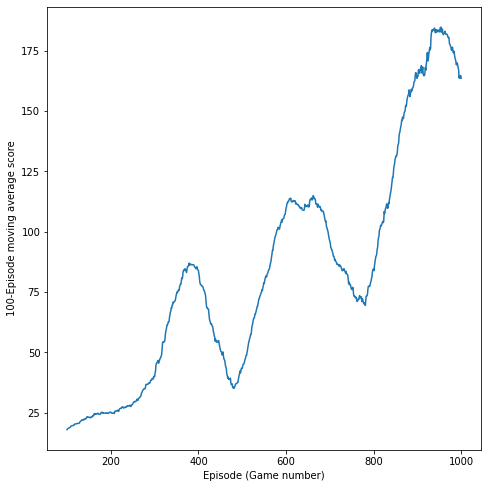

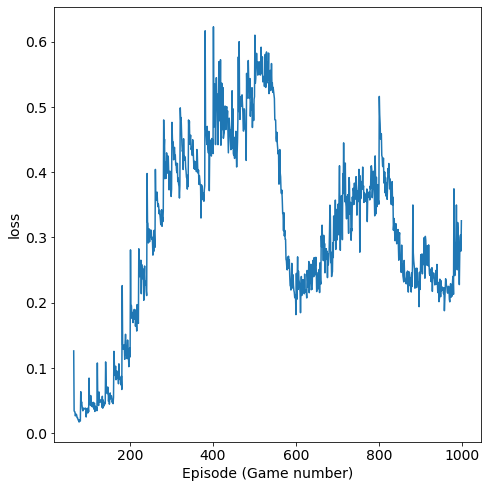

In [15]:
trainer_fr.plot_scores(100, "plots/pixel_cart_pole_score_mvg_fr.png")
trainer_fr.plot_loss("plots/pixel_cart_pole_loss_fr.png")

# Compare the two approaches

In [18]:
with open("models/trainer_scores.pickle", 'rb') as f:
  trainer_scores = pickle.load(f)

with open("models/pixel_cart_trainer_fr_score.pickle", 'rb') as f:
  trainer_fr_scores = pickle.load(f)

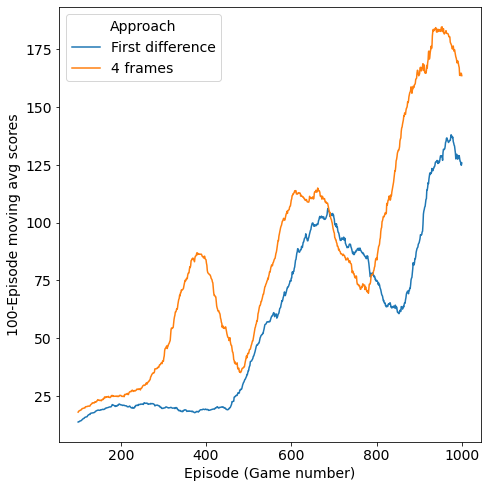

In [19]:
# get score comparison
plt.figure(figsize = (7,7))
trainer_mvg = trainer_fr.mvg_avg(trainer_scores, step_size = 100)
trainer_fr_mvg = trainer_fr.mvg_avg(trainer_fr.scores, step_size = 100)
plt.plot(trainer_mvg[0], trainer_mvg[1], label = 'First difference')
plt.plot(trainer_fr_mvg[0], trainer_fr_mvg[1], label = '4 frames')
plt.xlabel("Episode (Game number)")
plt.ylabel("100-Episode moving avg scores")
plt.legend(title = 'Approach')
plt.rcParams.update({'font.size': 14})
plt.tight_layout()
plt.savefig("plots/pixel_cart_pole_score_comparison.png", dpi = 300, bbox_inches = 'tight')
plt.show()

# playing the game with the optimal policy

In [38]:
# initialise the agent and load the policy and target networks
seed = 3108
n_episodes = 1000

eps_greedy = Exploration_profile(0.9,n_episodes,'eps_greedy',3)
final_agent = Agent(eps_greedy, 2, 0.5, horizontal_crop = True, seed = seed)
final_agent.initialise_game()

torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

policy_net = DQCNN(4, final_agent.state_shape, 2)
target_net = DQCNN(4, final_agent.state_shape, 2)
policy_net.load_state_dict(torch.load("models/trainer_fr_policy_net.pth"))
target_net.load_state_dict(torch.load("models/trainer_fr_target_net.pth"))

memory = ReplayMemory(10000)

final_trainer = Trainer(policy_net, target_net, memory, 20, -1, 0.99, 1e-4, 128, 4,seed)

In [39]:
final_trainer.play_game(final_agent)

Start playing...
Done - Score =  198 - Total Reward = 97.0


In [41]:
# save the according frames
if not os.path.isdir("plots/gifs/final_pixel_cart/"):
  os.makedirs("plots/gifs/final_pixel_cart/")
print('Saving game frames...')
# store the final game stages
for i in tqdm(range(len(final_trainer.game_frames))):
  plt.imshow(final_trainer.game_frames[i], cmap = 'gray')
  plt.xticks([])
  plt.yticks([])
  title = "Episode" + str(i)
  plt.title(title)
  plt.tight_layout()
  pth = "plots/gifs/final_pixel_cart/state_" + str(i) +".png"
  plt.savefig(pth, dpi = 300, bbox_inches='tight')
  plt.close()

Saving game frames...


100%|██████████| 100/100 [01:06<00:00,  1.50it/s]
